 In this notebook, all imported data is cleaned to prepare for analysis. The MSOAs used within the study are filtered out from Welsh and rural MSOAs with the use of the Spatial Signatures dataset. Amenities are aggregated to the MSOA level from LSOA using population-weighted aggregation, and the boundaries of the spatial dependency test in the West Midlands defined.

# Import Libraries

In [1]:
import pandas as pd
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
import os
import osmnx as ox
from sklearn.preprocessing import LabelEncoder
import joblib
import numpy as np
from matplotlib_scalebar.scalebar import ScaleBar

# Import Geographic Data, define functions

## Geographic files for LSOAs and MSOAs

In [2]:
lsoa = gpd.read_file("geographies/LSOA_2011_EW_BFC_shp/LSOA_2011_EW_BFC.shp")
#lsoa

In [4]:
lsoa_msoa_lookup_raw = pd.read_csv('geographies/PCD_OA_LSOA_MSOA_LAD_NOV22_UK_LU.csv', encoding='ISO-8859-1')
#lsoa_msoa_lookup_raw

/var/folders/lx/144t732x4hs49_9vxz4j63rh0000gn/T/ipykernel_8829/1164741725.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  lsoa_msoa_lookup_raw = pd.read_csv('geographies/PCD_OA_LSOA_MSOA_LAD_NOV22_UK_LU.csv', encoding='ISO-8859-1')


In [4]:
# Create lookup table from LSOA to MSOA
lsoa_msoa_lookup = lsoa_msoa_lookup_raw[['lsoa11cd', 'msoa11cd']].rename(columns={'lsoa11cd': 'LSOA11CD', 'msoa11cd': 'MSOA11CD'})
lsoa_msoa_lookup = lsoa_msoa_lookup.drop_duplicates(subset='LSOA11CD', keep='first')
#lsoa_msoa_lookup

In [5]:
# Set aside another lookup table for getting West Midlands MSOAs from Local Authority Districts
msoa_lad_lookup = lsoa_msoa_lookup_raw[['msoa11cd', 'ladcd', 'ladnm']].rename(columns={'msoa11cd': 'MSOA11CD'})
msoa_lad_lookup = msoa_lad_lookup.drop_duplicates(subset='MSOA11CD', keep='first')
#msoa_lad_lookup

In [6]:
# clean population data for weighted aggregation
lsoa_pop = pd.read_csv("geographies/lsoa_pop.csv")
lsoa_pop = lsoa_pop.iloc[3:].reset_index(drop=True)
col_names = lsoa_pop.iloc[0]  # Capture the 5th row which is now at index 0 after the drop
lsoa_pop = lsoa_pop[1:]  # Remove the first row
lsoa_pop.columns = col_names
lsoa_pop = lsoa_pop[['LSOA Code', 'All Ages']]
lsoa_pop.rename(columns={'LSOA Code': 'LSOA11CD', 'All Ages': 'USUALRES'}, inplace=True)

/var/folders/lx/144t732x4hs49_9vxz4j63rh0000gn/T/ipykernel_27059/2834104292.py:1: DtypeWarning: Columns (27,28,29,30,31,32,33,97) have mixed types. Specify dtype option on import or set low_memory=False.
  lsoa_pop = pd.read_csv("geographies/lsoa_pop.csv")


In [7]:
# add population data to LSOAs
lsoa = pd.merge(lsoa, lsoa_msoa_lookup, on='LSOA11CD')
lsoa = pd.merge(lsoa, lsoa_pop, on='LSOA11CD')
lsoa

,LSOA11CD,LSOA11NM,geometry,MSOA11CD,USUALRES
0,E01030056,Mid Suffolk 006B,"POLYGON ((602565.167 261619.354, 602568.750 26...",E02006266,"2,293"
1,E01030057,Mid Suffolk 007B,"POLYGON ((620353.125 257225.999, 620330.690 25...",E02006267,"2,365"
2,E01030054,Mid Suffolk 002B,"POLYGON ((607007.190 275966.413, 607006.813 27...",E02006262,"1,490"
3,E01030055,Mid Suffolk 002C,"POLYGON ((607480.834 271499.445, 607477.312 27...",E02006262,"1,402"
4,E01030052,Mid Suffolk 001A,"POLYGON ((613156.044 274811.514, 613146.313 27...",E02006261,"2,352"
...,...,...,...,...,...
34748,E01006188,Trafford 001F,"POLYGON ((381957.349 396101.460, 381957.640 39...",E02001259,"1,814"
34749,E01008189,Gateshead 023A,"POLYGON ((425883.822 558385.895, 425882.060 55...",E02001704,"1,190"
34750,E01008108,Sheffield 042A,"POLYGON ((435505.187 385687.682, 435507.914 38...",E02001652,"1,994"
34751,E01008188,Gateshead 022C,"POLYGON ((416288.482 560176.386, 416334.833 56...",E02001703,"1,363"


In [2]:
# import MSOA geography
msoa = gpd.read_file("geographies/MSOA_2011_EW_BFC_shp/MSOA_2011_EW_BFC.shp")

In [9]:
# Import MSOA population
msoa_pop = pd.read_csv("geographies/msoa_pop.csv")

In [10]:
# add population data to MSOA geographies
msoa_pop = msoa_pop.iloc[3:].reset_index(drop=True)
col_names = msoa_pop.iloc[0]  # Capture the 5th row which is now at index 0 after the drop
msoa_pop = msoa_pop[1:]  # Remove the first row
msoa_pop.columns = col_names
msoa_pop = msoa_pop[['MSOA Code', 'All Ages']]
msoa_pop.rename(columns={'MSOA Code': 'MSOA11CD', 'All Ages': 'USUALRES'}, inplace=True)
msoa = pd.merge(msoa, msoa_pop, on='MSOA11CD')
msoa

,MSOA11CD,MSOA11NM,geometry,USUALRES
0,E02000001,City of London 001,"POLYGON ((532153.703 182165.155, 532158.250 18...","10,938"
1,E02000002,Barking and Dagenham 001,"POLYGON ((548877.684 191097.284, 548877.386 19...","7,726"
2,E02000003,Barking and Dagenham 002,"POLYGON ((548958.555 189072.177, 548954.517 18...","11,246"
3,E02000004,Barking and Dagenham 003,"POLYGON ((551549.998 187364.637, 551528.633 18...","6,646"
4,E02000005,Barking and Dagenham 004,"POLYGON ((549237.051 187627.941, 549241.319 18...","10,540"
...,...,...,...,...
7196,W02000419,Denbighshire 017,"POLYGON ((302980.515 381530.795, 302977.621 38...","11,100"
7197,W02000420,Wrexham 020,"POLYGON ((335208.207 359993.832, 335211.594 35...","14,389"
7198,W02000421,Ceredigion 011,"POLYGON ((281669.829 291375.791, 281671.812 29...","11,623"
7199,W02000422,Cardiff 048,"MULTIPOLYGON (((322081.700 165165.900, 322082....","9,686"


## Define LSOA -> MSOA Data Aggregation Functions

In [11]:
# Convert gdfs to dfs
lsoa['area'] = lsoa.geometry.area
msoa['area'] = msoa.geometry.area

lsoa_df = pd.DataFrame(lsoa.drop(columns='geometry'))
msoa_df = pd.DataFrame(msoa.drop(columns='geometry')) 

# merge lsoa to msoa 
merged_df = pd.merge(lsoa_df, msoa_df, on='MSOA11CD', suffixes=('_lsoa', '_msoa'))
    
# drop all columns except for MSOA code, LSOA code, LSOA population, MSOA populationm
merged_df = merged_df[['MSOA11CD', 'LSOA11CD', 'USUALRES_lsoa', 'USUALRES_msoa', 'area_lsoa', 'area_msoa']]

# calculate the population percentage for each LSOA within its MSOA
merged_df['USUALRES_lsoa'] = pd.to_numeric(merged_df['USUALRES_lsoa'].str.replace(',', ''), errors='coerce')
merged_df['USUALRES_msoa'] = pd.to_numeric(merged_df['USUALRES_msoa'].str.replace(',', ''), errors='coerce')
merged_df['population_percentage'] = merged_df['USUALRES_lsoa'] / merged_df['USUALRES_msoa']
merged_df['area_percentage'] = merged_df['area_lsoa'] / merged_df['area_msoa']

merged_df = merged_df[['MSOA11CD', 'LSOA11CD', 'population_percentage', 'area_percentage']]
print(merged_df)

        MSOA11CD   LSOA11CD  population_percentage  area_percentage
0      E02006266  E01030056               0.237223         0.275174
1      E02006266  E01030051               0.180012         0.024328
2      E02006266  E01030065               0.229568         0.455847
3      E02006266  E01030086               0.130250         0.134429
4      E02006266  E01030089               0.222946         0.110221
...          ...        ...                    ...              ...
34748  E02001275  E01006106               0.184028         0.046488
34749  E02001275  E01006107               0.176629         0.830110
34750  E02001275  E01006104               0.175690         0.045799
34751  E02001275  E01006105               0.257428         0.055786
34752  E02001275  E01006108               0.206224         0.021817

[34753 rows x 4 columns]


In [12]:
def aggregate_and_weight_data(dataset, columns_to_aggregate, metric):
    # Left join the dataset to the percentage DataFrame on LSOA code
    dataset_merged = pd.merge(dataset, merged_df, on='LSOA11CD')

    # Create a new DataFrame to hold the results
    result_df = pd.DataFrame()
    result_df['MSOA11CD'] = dataset_merged['MSOA11CD'].unique()  # Initialize with MSOA codes

    # Iterate over each specified column to aggregate
    for col_name in columns_to_aggregate:
        if col_name in dataset.columns:
            # Ensure the column of interest is numeric
            dataset_merged[col_name] = pd.to_numeric(dataset_merged[col_name], errors='coerce')

            # Multiply the column of interest by the population percentage
            weighted_col_name = f"weighted_value_{col_name}"
            dataset_merged[weighted_col_name] = dataset_merged[col_name] * dataset_merged[metric]

            # Aggregate the weighted values by MSOA code
            aggregated_values = dataset_merged.groupby('MSOA11CD')[weighted_col_name].sum().reset_index()

            # Merge the aggregated values back into the result_df
            result_df = pd.merge(result_df, aggregated_values, on='MSOA11CD', how='left')

    return result_df

## Define function to drop rural or Welsh MSOAs

In [93]:
# Get spatial signatures file
spatsig = pd.read_csv("raw_y_values/spatial_signature.csv")

In [101]:
# Aggregate LSOA-level to MSOA level
dataset = spatsig
columns_to_aggregate = ['COA', 'ACS', 'OPS', 'WIC',
       'WAL', 'GRQ', 'URB', 'DIS', 'DRN', 'CRN', 'DUN', 'LOU', 'DIU', 'REU',
       'OUT', 'MEU', 'HDU']
metric = 'area_percentage'
aggregated_spatsig = aggregate_and_weight_data(dataset, columns_to_aggregate, metric)

In [112]:
# Drop MSOAs that are majority rural / unpopulated - urban buffer, countryside agriculture, wild countryside
# Dropping warehouse / parkland was also considered but looking at the map they were often quite built-up areas
columns_to_sum = ['weighted_value_COA', 'weighted_value_WIC', 'weighted_value_URB']
rural_aggregated = aggregated_spatsig
rural_aggregated['sum_of_columns'] = rural_aggregated[columns_to_sum].sum(axis=1)
# Drop rows where the sum of the columns is more than 0.5
rural_aggregated = rural_aggregated[rural_aggregated['sum_of_columns'] <= 0.5]
# Drop rural sum column
rural_aggregated = rural_aggregated.drop(columns=['sum_of_columns'])

In [113]:
# Create column name / land type dict
code_type_dict = spatsig.set_index('primary_code')['primary_type'].to_dict()

# Find the column name with the maximum value for each row
spatsig_cols = rural_aggregated.iloc[:, 1:]
max_col_names = spatsig_cols.idxmax(axis=1)

# Map the land type codes to their assigned numbers using code_to_number_dict
rural_aggregated['spatial_signature'] = max_keys.map(code_type_dict)

# Create the final df with MSOA11CD and y_true_value
spatial_signature = rural_aggregated[['MSOA11CD', 'spatial_signature']]

In [115]:
# Save copy of spatial signature file to exclude rural graphs
spatial_signature.to_csv('geographies/nonrural_MSOAs.csv', index=False)

In [72]:
# Function to filter out welsh and rural MSOAs
def filter_urban_english(df):
    # Load non-rural MSOA codes from a CSV file into a pandas DataFrame
    nonrural_MSOAs = pd.read_csv('geographies/nonrural_MSOAs.csv')
    nonrural_MSOAs_set = set(nonrural_MSOAs['MSOA11CD'])

    # Filter the DataFrame to exclude Welsh MSOAs
    filtered_df = df[~df['MSOA11CD'].str.startswith('W02')]

    # Further filter to keep only rows where 'MSOA11CD' is in the nonrural MSOAs set
    filtered_df = filtered_df[filtered_df['MSOA11CD'].isin(nonrural_MSOAs_set)]

    return filtered_df

## Define plotting functions

In [15]:
def plot_zoomed_cities(df, y_column, legend_title, plot_title):
    # Define layout with explicit placeholders for the colorbar
    layout = [
        ["A", "B", "colorbar"],
        ["C", "D", "colorbar"]
    ]
    # Define the figure and axes with adjusted width ratios to fit the colorbar
    fig, axs = plt.subplot_mosaic(layout, figsize=(11, 10), constrained_layout=True,
                                  gridspec_kw={'width_ratios': [1, 1, 0.05], 'height_ratios': [1, 1]})

    gdf = msoa.merge(df, on='MSOA11CD', how='left')

    city_centers = [(53.491013, -2.314446), (54.983156, -1.608169), 
                    (52.497836, -1.965555), (51.506392, -0.112552)]
    city_names = ["Manchester", "Newcastle", "Birmingham", "London"]


    # Create a GeoDataFrame with city centers in EPSG:4326
    city_centers_gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy([lng for lat, lng in city_centers], 
                                                                    [lat for lat, lng in city_centers]), 
                                        crs="EPSG:4326")
    
    # Transform to OSGB36 / British National Grid
    city_centers_gdf = city_centers_gdf.to_crs(epsg=27700)

    buffer = 25000  # Buffer in meters (adjust if necessary)

    for pos, (index, row) in zip(['A', 'B', 'C', 'D'], city_centers_gdf.iterrows()):
        ax = axs[pos]
        point = row.geometry
        minx, maxx = point.x - buffer, point.x + buffer
        miny, maxy = point.y - buffer, point.y + buffer

        ax.set_xlim(minx, maxx)
        ax.set_ylim(miny, maxy)
        
        # Increase the opacity of the polygons
        gdf.plot(column=y_column, ax=ax, alpha=0.8, legend=False, cmap='RdYlGn',  edgecolor='black', linewidth=0.1)

        # Add North Arrow
        ax.annotate('N', xy=(0.96, 0.15), xycoords='axes fraction', xytext=(0.96, 0.1), 
            textcoords='axes fraction', arrowprops=dict(facecolor='black', arrowstyle="->"), 
            ha='center')

        # Add Scale Bar
        scalebar = ScaleBar(1, "m", length_fraction=0.25, location='lower right', scale_loc='top')
        ax.add_artist(scalebar)


        try:
            cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik, zoom=10)
        except Exception as e:
            print(f"Failed to add basemap: {e}")

        # Move title to below the plot
        ax.set_title(city_names[index], position=(0.5, -1))

        ax.set_xticks([])
        ax.set_yticks([])

    # Ensure the 'colorbar' key accesses the correct axis and doesn't overlap plots
    cax = axs['colorbar']  # Single colorbar axis defined in layout
    sm = plt.cm.ScalarMappable(cmap='RdYlGn', norm=plt.Normalize(vmin=gdf[y_column].min(), vmax=gdf[y_column].max()))
    sm._A = []
    fig.colorbar(sm, cax=cax, orientation='vertical').set_label(legend_title)

    # Add an overall title
    fig.suptitle(f'{plot_title}', fontsize=16)
    
    plt.show()

In [13]:
def plot_truth(plot_name, y_file, task_type, legend_title, column_name, colors):
    geo_y_truth = msoa.merge(y_file, on='MSOA11CD', how='left')

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    
    if task_type == 'classification':
        cmap = colors
        plot = geo_y_truth.plot(column=column_name, ax=ax, alpha=1, categorical=True, legend=True, cmap=cmap, edgecolor='none')
        legend = ax.get_legend()
        if legend:
            legend.set_bbox_to_anchor((1, 1))
            legend.set_title(legend_title, prop={'size': 7})
    elif task_type == 'regression':
        cmap = 'RdYlGn'  # Suitable for continuous data
        plot = geo_y_truth.plot(column=column_name, ax=ax, alpha=1, legend=False, cmap=cmap, edgecolor='none')
        # Create a color bar
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=geo_y_truth[column_name].min(), vmax=geo_y_truth[column_name].max()))
        sm._A = []  # Empty array for the data range
        cbar = fig.colorbar(sm, ax=ax, fraction=0.037, pad=0.04, location='left')
        cbar.set_label(legend_title)

    # Add basemap
    cx.add_basemap(ax, crs=msoa.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)
    ax.set_title(plot_name, position=(0.5, -0.1))
    ax.set_xticks([])
    ax.set_yticks([])

    # Add North Arrow
    ax.annotate('N', xy=(0.96, 0.15), xycoords='axes fraction', xytext=(0.96, 0.1), 
                textcoords='axes fraction', arrowprops=dict(facecolor='black', arrowstyle="->"), 
                ha='center')

    # Add Scale Bar
    scalebar = ScaleBar(1, "m", length_fraction=0.25, location='lower right', scale_loc='top')
    ax.add_artist(scalebar)

    # Adding title and labels
    plt.title(f'{plot_name}')

    # Remove the x and y axis ticks
    ax.set_xticks([])
    ax.set_yticks([])

    # Show plot
    plt.show()

In [61]:
# Check data distribution
def plot_predicted_data_distribution(df, column, title, legend):
    #df[column] = df[column].astype(int)  # Convert to int
    fig, ax = plt.subplots(figsize=(10, 6))
    bins = np.linspace(df[column].min(), 
                       df[column].max(), 30)
    ax.hist(df[column], bins=bins, alpha=0.5, color='black')
    ax.set_title(title)
    ax.set_xlabel(legend)
    ax.set_ylabel('Density')
    ax.legend()
    plt.show()

# Clean data, apply data aggregation, save files

### Amenity data

In [38]:
# function to drop unnecessary rows and columns from amenity datasets
def process_amenity_data(df, column):
    # Find the first row
    header_row_idx = df[df.iloc[:, 0].str.contains('LSOA_code', na=False)].index.min()
    
    # Skip all rows up to the header row and set the header row as the new column names
    df = df.iloc[header_row_idx:]
    df.columns = df.iloc[0]
    df = df[1:]  # Drop the row used as column names
    
    # Reset index for the cleaned DataFrame
    df.reset_index(drop=True, inplace=True)
    
    # Reset index for the cleaned DataFrame
    df.reset_index(drop=True, inplace=True)

    #drop all columns but LSOA11CD and walk15pct
    df = df.filter(regex=f'LSOA_code|{column}$', axis=1)
    return df

In [33]:
# function to merge amenity datasets
def process_and_merge(dflist):
    merged_df = process_amenity_data(dflist[0], 'Walk15n')

    # Iterate over the remaining dataframes in the list
    for df in dflist[1:]:
        # Process each dataframe
        processed_df = process_amenity_data(df, 'Walk15n')
        # Merge with the running total
        merged_df = pd.merge(merged_df, processed_df, on='LSOA_code')

    return merged_df

#### Process amenity data

In [35]:
# import datasets
primary_school_raw = pd.read_csv("raw_y_values/primaryschool.csv")
secondary_school_raw = pd.read_csv("raw_y_values/secondary_school.csv")
further_ed_raw = pd.read_csv("raw_y_values/further_ed.csv")
gp_raw = pd.read_csv("raw_y_values/gp.csv")
hospital_raw = pd.read_csv("raw_y_values/hospitals.csv")
foodstore_raw = pd.read_csv("raw_y_values/foodstore.csv")
employment_raw = pd.read_csv("raw_y_values/employment.csv")

/var/folders/lx/144t732x4hs49_9vxz4j63rh0000gn/T/ipykernel_27059/3196957243.py:1: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  primary_school_raw = pd.read_csv("raw_y_values/primaryschool.csv")
/var/folders/lx/144t732x4hs49_9vxz4j63rh0000gn/T/ipykernel_27059/3196957243.py:2: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  secondary_school_raw = pd.read_csv("raw_y_values/secondary_school.csv")
/var/folders/lx/144t732x4hs49_9vxz4j63rh0000gn/T/ipykernel_27059/3196957243.py:3: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  

In [117]:
# Process raw data
dflist = [primary_school_raw, secondary_school_raw, further_ed_raw, gp_raw, hospital_raw, foodstore_raw]
n_amenities_15min = process_and_merge(dflist)

# Find sum
n_amenities_15min.iloc[:, -3:] = n_amenities_15min.iloc[:, -3:].apply(pd.to_numeric, errors='coerce')
n_amenities_15min['total_number'] = n_amenities_15min.iloc[:, -3:].sum(axis=1)
n_amenities_15min.rename(columns={'LSOA_code': 'LSOA11CD'}, inplace=True)

In [118]:
# Aggregate Data
dataset = n_amenities_15min
columns_to_aggregate = ['total_number']
metric = 'population_percentage'

n_amenities_15min = aggregate_and_weight_data(dataset, columns_to_aggregate, metric)
n_amenities_15min.rename(columns={'weighted_value_total_number': 'n_amenities_15min'}, inplace=True)

# Remove rural / Welsh MSOAs
n_amenities_15min = filter_urban_english(n_amenities_15min)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


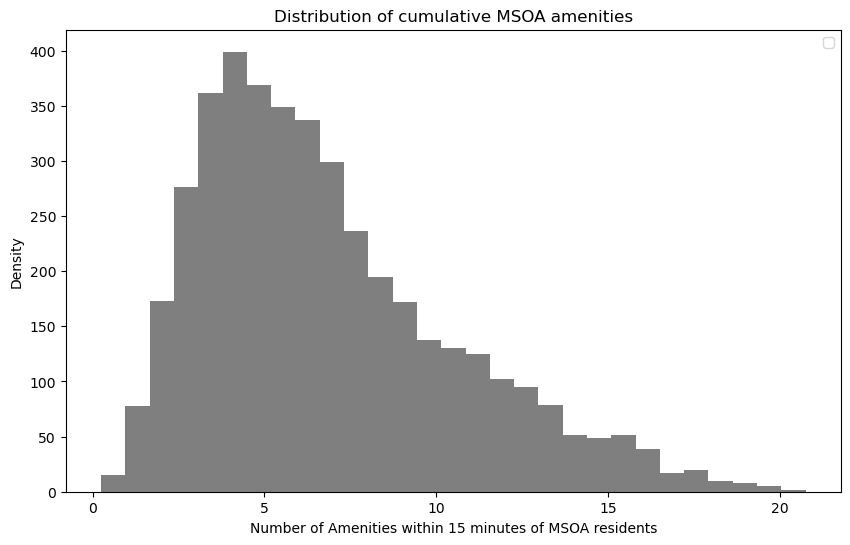

In [119]:
# visualize distribution
df = n_amenities_15min
column = 'n_amenities_15min'
title = 'Distribution of cumulative MSOA amenities'
legend = 'Number of Amenities within 15 minutes of MSOA residents'

plot_predicted_data_distribution(df, column, title, legend)

In [120]:
# Check data
n_amenities_15min

,MSOA11CD,n_amenities_15min
0,E02000001,13.198757
1,E02000017,14.970280
2,E02000016,15.771705
3,E02000014,11.457756
4,E02000010,11.868395
...,...,...
6786,E02006907,8.946863
6787,E02006899,12.000000
6788,E02006917,11.792418
6789,E02006933,7.461373


In [121]:
# Save file
n_amenities_15min.to_csv('clean_y_values/y_n_amenities_15min.csv', index=False)

# Save extra one for a positional encoding test
n_amenities_15min.to_csv('clean_y_values/y_n_amenities_15min_pos_enc.csv', index=False)

### Visualized Amenity Data

In [5]:
n_amenities_15min = pd.read_csv('clean_y_values/y_n_amenities_15min.csv')

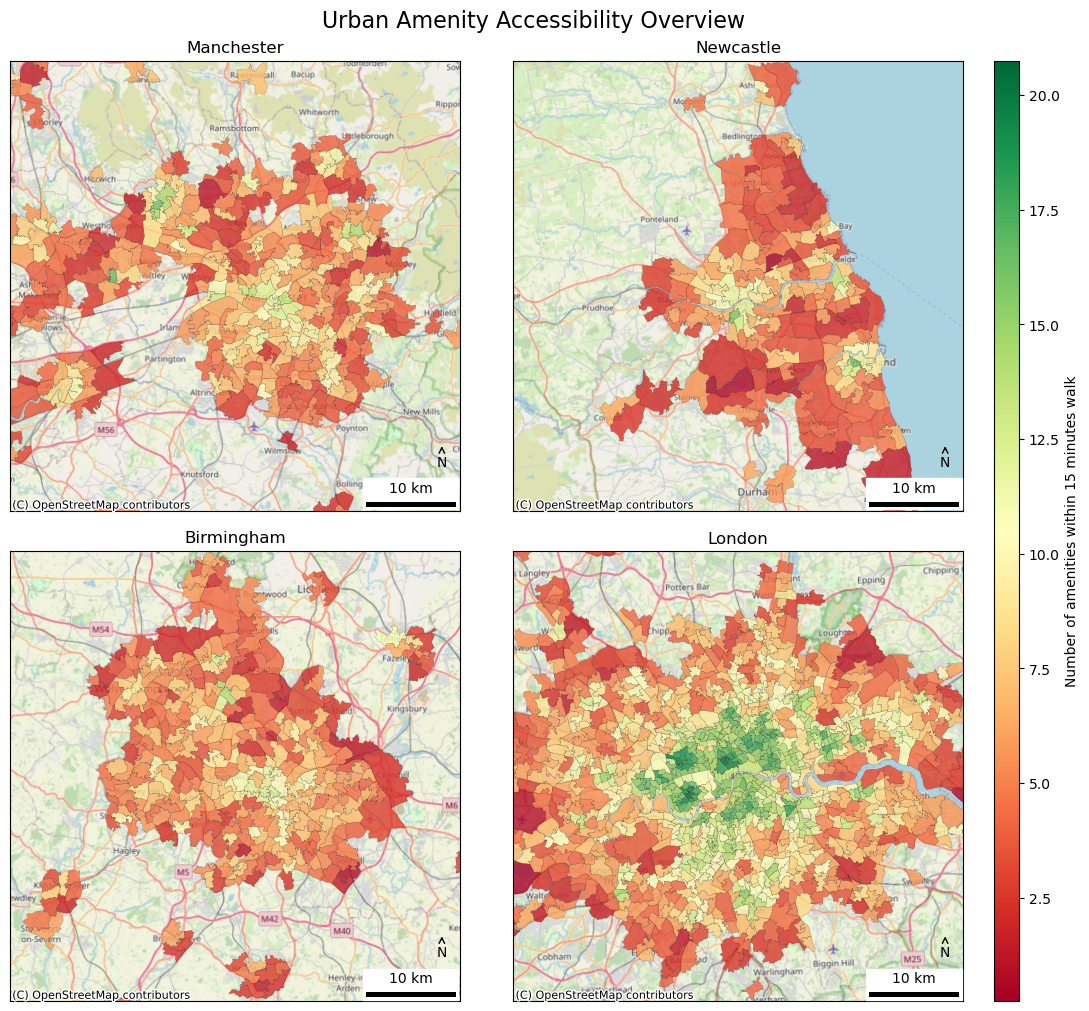

In [17]:
# Plot data
df=n_amenities_15min
y_column='n_amenities_15min'
legend_title = 'Number of amenities within 15 minutes walk'
plot_title = 'Urban Amenity Accessibility Overview'
plot_zoomed_cities(df, y_column, legend_title, plot_title)

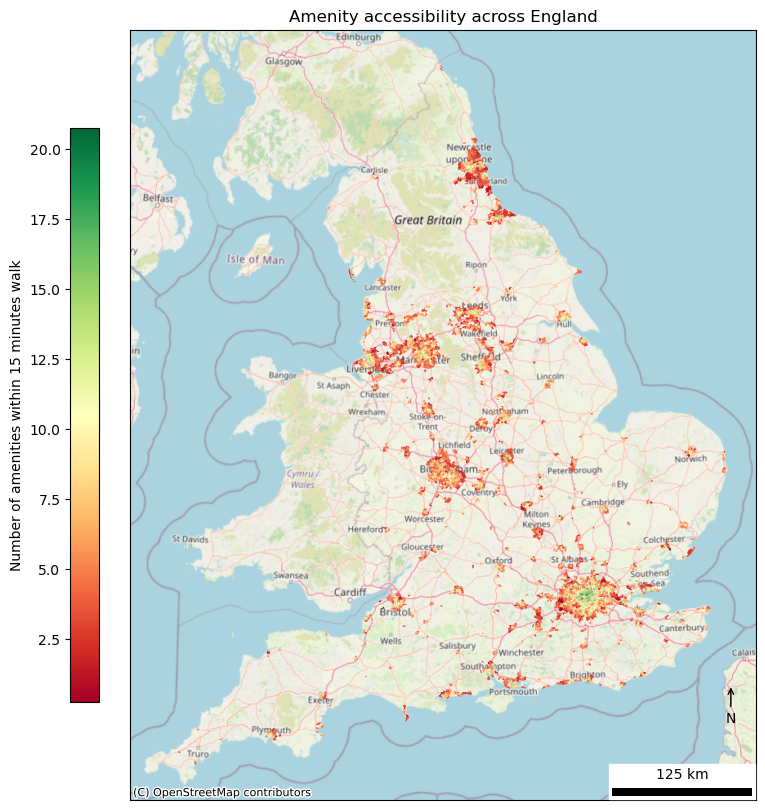

In [14]:
plot_name = 'Amenity Accessibility across England'
y_file = n_amenities_15min
column_name='n_amenities_15min'
legend_title = 'Number of amenities within 15 minutes walk'
task_type = 'regression'
colors = 'RdGn'

plot_truth(plot_name, y_file, task_type, legend_title, column_name, colors)

## Isolate West Midlands for Spatial Dependency Check

In [58]:
# create list of West Midlands MSOAs for exclusion
west_midlands = ['Birmingham', 'Sandwell', 'Dudley', 'Wolverhampton', 'Walsall', 'North Warwickshire', 'Solihull', 'Coventry',
                 'Cannock Chase', 'North Warwickshire', 'Nuneaton and Bedworth', 'Redditch', 'Rugby',
                 'Shropshire', 'Stratford-on-Avon', 'Tamworth', 'Telford and Wrekin', 'Warwickshire', 'South Staffordshire',
                 'Lichfield', 'Wyre Forest', 'Bromsgrove', 'Worcester', 'Warwick', 'Wychavon', 'Malvern Hills', 'Herefordshire, County of',
                 'Hinckley and Bosworth']

In [59]:
# filter out Welsh/rural MSOAs
spatial_dependency_data = msoa_lad_lookup
spatial_dependency_data['MSOA11CD'] = spatial_dependency_data['MSOA11CD'].astype(str)
spatial_dependency_data.dropna(subset=['MSOA11CD'], inplace=True)
spatial_dependency_data = filter_urban_english(spatial_dependency_data)

In [60]:
# Add new column informing if data is for testing or training
# This is mostly for visualization
conditions = [spatial_dependency_data['ladnm'].isin(west_midlands)]
choices = ['West Midlands Test Data']

# Apply conditions and choices to create a new column
spatial_dependency_data['Data Category'] = np.select(conditions, choices, default='Training Data')

In [61]:
# Count number of test rows
count = (spatial_dependency_data['Data Category'] == 'West Midlands Test Data').sum()
count

464

In [35]:
# Count number of test rows
count = (spatial_dependency_data['ladnm'] == 'Herefordshire, County of').sum()
count

5

In [130]:
# Save data
spatial_dependency_data.to_csv('geographies/spatial_dependency_data.csv', index=False)

In [68]:
y_file = spatial_dependency_data
task_type = 'classification'
column_name = 'Data Category'
plot_name = 'Spatial Dependency Test Data'
legend_title = 'Data Category'
colors = plt.cm.get_cmap('bwr', 2)

/var/folders/lx/144t732x4hs49_9vxz4j63rh0000gn/T/ipykernel_8829/4183550885.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('bwr', 2)


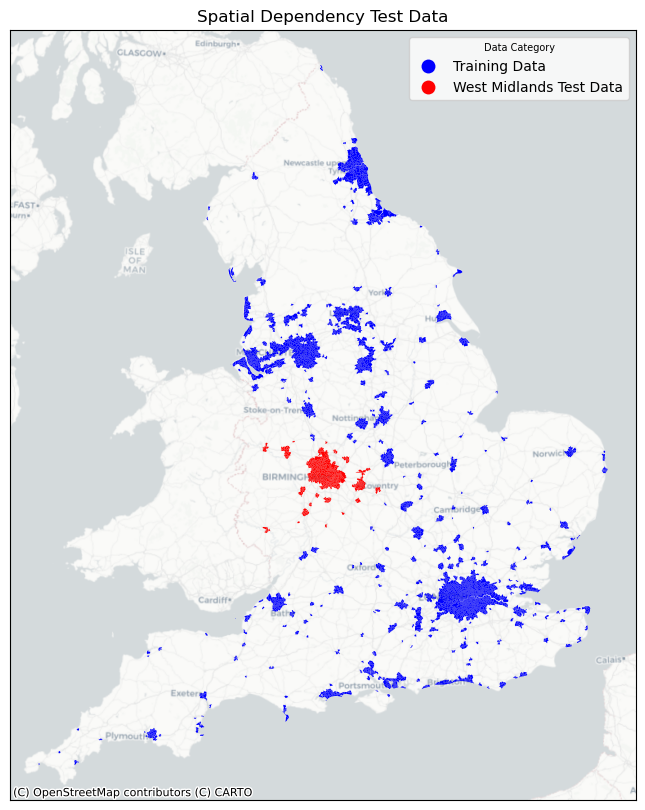

In [69]:
plot_truth(plot_name, y_file, task_type, legend_title, column_name, colors)

# Save node/edge files for graphs

In [2]:
msoa = gpd.read_file("geographies/MSOA_2011_EW_BFC_shp/MSOA_2011_EW_BFC.shp")
msoa = msoa[msoa.is_valid]
print(msoa.crs)
msoa

PROJCS["OSGB36 / British National Grid",GEOGCS["OSGB36",DATUM["Ordnance_Survey_of_Great_Britain_1936",SPHEROID["Airy 1830",6377563.396,299.3249646,AUTHORITY["EPSG","7001"]],AUTHORITY["EPSG","6277"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scale_factor",0.999601272],PARAMETER["false_easting",400000],PARAMETER["false_northing",-100000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


,MSOA11CD,MSOA11NM,geometry
0,E02000001,City of London 001,"POLYGON ((532153.703 182165.155, 532158.250 18..."
1,E02000002,Barking and Dagenham 001,"POLYGON ((548877.684 191097.284, 548877.386 19..."
2,E02000003,Barking and Dagenham 002,"POLYGON ((548958.555 189072.177, 548954.517 18..."
3,E02000004,Barking and Dagenham 003,"POLYGON ((551549.998 187364.637, 551528.633 18..."
4,E02000005,Barking and Dagenham 004,"POLYGON ((549237.051 187627.941, 549241.319 18..."
...,...,...,...
7196,W02000419,Denbighshire 017,"POLYGON ((302980.515 381530.795, 302977.621 38..."
7197,W02000420,Wrexham 020,"POLYGON ((335208.207 359993.832, 335211.594 35..."
7198,W02000421,Ceredigion 011,"POLYGON ((281669.829 291375.791, 281671.812 29..."
7199,W02000422,Cardiff 048,"MULTIPOLYGON (((322081.700 165165.900, 322082...."


In [3]:
# Drop Welsh MSOAs as much of the Y value data doesn't cover them
msoa = msoa[~msoa['MSOA11CD'].str.startswith('W02')]
msoa

,MSOA11CD,MSOA11NM,geometry
0,E02000001,City of London 001,"POLYGON ((532153.703 182165.155, 532158.250 18..."
1,E02000002,Barking and Dagenham 001,"POLYGON ((548877.684 191097.284, 548877.386 19..."
2,E02000003,Barking and Dagenham 002,"POLYGON ((548958.555 189072.177, 548954.517 18..."
3,E02000004,Barking and Dagenham 003,"POLYGON ((551549.998 187364.637, 551528.633 18..."
4,E02000005,Barking and Dagenham 004,"POLYGON ((549237.051 187627.941, 549241.319 18..."
...,...,...,...
6786,E02006930,Greenwich 037,"POLYGON ((539484.093 178619.500, 539498.046 17..."
6787,E02006931,Greenwich 038,"POLYGON ((538643.172 178080.498, 538663.086 17..."
6788,E02006932,Liverpool 060,"POLYGON ((335723.000 391178.000, 335737.212 39..."
6789,E02006933,Liverpool 061,"POLYGON ((335092.820 390247.045, 335093.000 39..."


In [5]:
directory = "EW_msoa_node_edge_drive"
unsuccessful_msoas = []  # List to track MSOAs with errors
original_gdf = msoa

for index, msoa_row in original_gdf.iterrows():
    subdirectory = os.path.join(directory, msoa_row['MSOA11CD'])
    
    # Check if subdirectory already has the required files
    nodes_filepath = os.path.join(subdirectory, 'node_list.csv')
    edges_filepath = os.path.join(subdirectory, 'edge_list.csv')
    
    # If both files exist, skip this MSOA
    if os.path.exists(nodes_filepath) and os.path.exists(edges_filepath):
        #print(f"Files already exist for {lsoa['LSOA11CD']}, skipping...")
        continue
    
    # Ensure directory exists without raising an error
    os.makedirs(subdirectory, exist_ok=True)
    
    # Ensure the polygon is in EPSG:4326 for OSMnx
    single_msoa_gdf = gpd.GeoDataFrame([msoa_row], crs=msoa.crs, geometry=[msoa_row['geometry']])
    single_msoa_gdf = single_msoa_gdf.set_geometry('geometry')
    single_msoa_gdf = single_msoa_gdf.to_crs(epsg=4326)
    geometry = single_msoa_gdf.geometry.iloc[0]
    
    try:
        # Extract street network within the MSOA polygon
        graph = ox.graph_from_polygon(geometry, network_type='drive')
        
        # Convert the graph to GeoDataFrames
        nodes_gdf, edges_gdf = ox.graph_to_gdfs(graph)
        
        # Reset the index to turn the 'u' and 'v' index into columns
        edges_gdf.reset_index(inplace=True)
        nodes_gdf.reset_index(inplace=True)

        # Save to CSV
        nodes_gdf.to_csv(nodes_filepath, index=False)
        edges_gdf.to_csv(edges_filepath, index=False)
        #confirm
        print(f"{msoa_row['MSOA11CD']} saved successfully")

    except Exception as e:  # Catch all exceptions and log them
        print(f"Failed to process {msoa_row['MSOA11CD']}: {str(e)}")
        unsuccessful_msoas.append(msoa_row['MSOA11CD'])
        continue

E02000001 saved successfully
E02000002 saved successfully
E02000003 saved successfully
E02000004 saved successfully
E02000005 saved successfully
E02000007 saved successfully
E02000008 saved successfully
E02000009 saved successfully
E02000010 saved successfully
E02000011 saved successfully
E02000012 saved successfully
E02000013 saved successfully
E02000014 saved successfully
E02000015 saved successfully
E02000016 saved successfully
E02000017 saved successfully
E02000018 saved successfully
E02000019 saved successfully
E02000020 saved successfully
E02000021 saved successfully
E02000022 saved successfully
E02000023 saved successfully
E02000024 saved successfully
E02000025 saved successfully
E02000026 saved successfully
E02000027 saved successfully
E02000028 saved successfully
E02000029 saved successfully
E02000030 saved successfully
E02000031 saved successfully
E02000032 saved successfully
E02000033 saved successfully
E02000034 saved successfully
E02000035 saved successfully
E02000036 save

In [6]:
unsuccessful_msoas

['E02000994',
 'E02001359',
 'E02001713',
 'E02001779',
 'E02002614',
 'E02002693',
 'E02003173',
 'E02003842']